In [2]:
from sklearn.cluster import  MiniBatchKMeans, KMeans, DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import math
from pylab import *
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline 

In [3]:
import folium
import json
from IPython.display import HTML

In [4]:
def find_unique(data, field):
    data_not_null=data[data[field].notnull()]
    duplicate_index=data_not_null.duplicated(field)
    unique=data_not_null[~duplicate_index]
    return unique

In [5]:
building_SF = pd.read_csv('C:\Users\Olga\Documents\RENUWIT\Urine_separation\shapefiles\\building_block_people_WGS_2.csv')

In [6]:
building_SF['num_people_int']=building_SF.num_people.round()

In [7]:
building_SF_array=np.array(building_SF)

In [8]:
building_virtual_buildings=[]
for row in building_SF_array:
    for i in range(int(row[-1])):
        building_virtual_buildings.append(row)
        

In [9]:
columns=['gid', 'fid_buildi', 'objname', 'numfaces', 'num_floor',
       'fid_landus', 'blklot', 'block_num', 'lot_num', 'resunits',
       'landuse', 'bldgsqft', 'yrbuilt', 'area_m2', 'county',
       'fid_tabblo', 'tractce10', 'housing10', 'lat', 'lon',
       'num_people', 'pop10', 'lat_lat', 'lon_lon', 'num_people_int']
building_virtual_buildings_df=pd.DataFrame(building_virtual_buildings, columns=columns)

In [10]:
building_virtual_buildings_df.to_csv('C:\Users\Olga\Documents\RENUWIT\Urine_separation\shapefiles\\building_virtual_buildings_WGS.csv')

In [11]:
building_SF_points=building_virtual_buildings_df[['lat_lat','lon_lon']]
data_plot=np.asarray(building_SF_points[:])

In [12]:
n = 20
k_means = KMeans(init='k-means++', n_clusters=n)
k_means.fit(building_SF_points)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [13]:
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)
ft = (k_means_labels, k_means_cluster_centers)

C:\Users\Olga\Anaconda2\lib\site-packages\matplotlib\lines.py:1107: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:


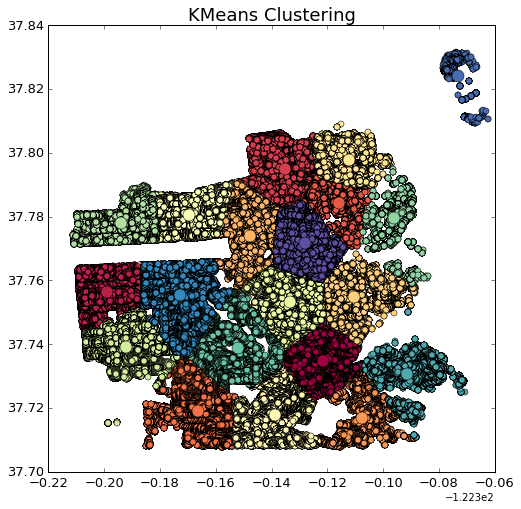

In [14]:
fig = plt.figure(figsize=(8, 8))
colors = plt.cm.Spectral(np.linspace(0, 1, n))

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(n), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(data_plot[my_members, 1], data_plot[my_members, 0], 'w',
            markerfacecolor=col, marker='o', markersize=6)
    plt.plot(cluster_center[1], cluster_center[0], 'o',
            markerfacecolor=col, markeredgecolor='k', markersize=12)    
plt.title('KMeans Clustering',fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [55]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [15]:
size_all= []
for i in range (k_means_labels.max()):
    my_members = k_means_labels==i
    unique = find_unique(building_virtual_buildings_df[my_members],'gid')
    size_all.append(unique)

In [56]:
size_all_distance=[[] for i in range(k_means_labels.max())]
for i in range (k_means_labels.max()):
    for index, row in size_all[i].iterrows():
        harv=haversine(row['lat'],row['lon'], k_means_cluster_centers[i][0], k_means_cluster_centers[i][1])
        row['eu_dist'] = harv
        size_all_distance[i].append(row)

size_all_distance=[[] for i in range(k_means_labels.max())]
for i in range (k_means_labels.max()):
    for index, row in size_all[i].iterrows():
        point_lat_lon = [[row['lat'], row['lon']]]
        cluster_lat_lon = [[k_means_cluster_centers[i][0], k_means_cluster_centers[i][1]]]
        eu = cdist(point_lat_lon,cluster_lat_lon, 'euclidean')
        dist = eu[0][0]
        row['eu_dist'] = dist
        size_all_distance[i].append(row)

In [17]:
n2 = 1
k_means_2 = KMeans(init='k-means++', n_clusters=n2)
k_means_2.fit(k_means_cluster_centers)

k_means_labels_2 = k_means_2.labels_
k_means_cluster_centers_2 = k_means_2.cluster_centers_
k_means_labels_unique_2 = np.unique(k_means_labels_2)
ft = (k_means_labels_2, k_means_cluster_centers_2)

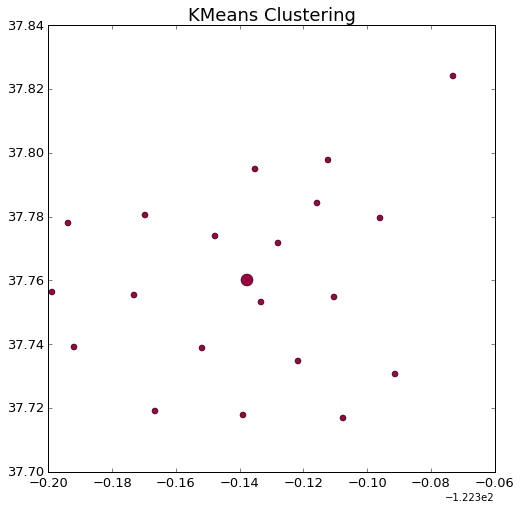

In [18]:
fig = plt.figure(figsize=(8, 8))
colors = plt.cm.Spectral(np.linspace(0, 1, n2))

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(n2), colors):
    my_members = k_means_labels_2 == k
    cluster_center = k_means_cluster_centers_2[k]
    plt.plot(k_means_cluster_centers[my_members, 1], k_means_cluster_centers[my_members, 0], 'w',
            markerfacecolor=col, marker='o', markersize=6)
    plt.plot(cluster_center[1], cluster_center[0], 'o',
            markerfacecolor=col, markeredgecolor='k', markersize=12)    
plt.title('KMeans Clustering',fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [35]:
map_osm = folium.Map(location=[37.6236, -122.3750])
for item in k_means_cluster_centers:
    folium.RegularPolygonMarker(
    item,
    popup='Hawthorne Bridge',
    fill_color='#DC143C',
    number_of_sides=4,
    radius=7
    ).add_to(map_osm)
folium.RegularPolygonMarker(
cluster_center,
popup='Hawthorne Bridge',
fill_color='#00FFFF',
number_of_sides=6,
radius=10
).add_to(map_osm)

map_osm

In [51]:
total_dist_all=[]
for i in range (k_means_labels.max()):
    df = pd.DataFrame(size_all_distance[i])
    total_dist = df['eu_dist'].sum()
    total_peop = df['num_people_int'].sum()
    all_totals = (i, total_peop, total_dist)
    total_dist_all.append(all_totals)

In [52]:
totals_all_df = pd.DataFrame(total_dist_all, columns=['cluster', 'num_people', 'total_dist_m'])

In [ ]:
totals_all_df.to_csv('C:\Users\Olga\Documents\RENUWIT\Urine_separation\shapefiles\\totals_all_df_%d.csv' % n)

In [37]:
import doctest
from itertools import permutations


def distance(point1, point2):
    """
    Returns the Euclidean distance of two points in the Cartesian Plane.

    >>> distance([3,4],[0,0])
    5.0
    >>> distance([3,6],[10,6])
    7.0
    """
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) ** 0.5


def total_distance(points):
    """
    Returns the length of the path passing throught
    all the points in the given order.

    >>> total_distance([[1,2],[4,6]])
    5.0
    >>> total_distance([[3,6],[7,6],[12,6]])
    9.0
    """
    return sum([distance(point, points[index + 1]) for index, point in enumerate(points[:-1])])


def travelling_salesman(points, start=None):
    """
    Finds the shortest route to visit all the cities by bruteforce.
    Time complexity is O(N!), so never use on long lists.

    >>> travelling_salesman([[0,0],[10,0],[6,0]])
    ([0, 0], [6, 0], [10, 0])
    >>> travelling_salesman([[0,0],[6,0],[2,3],[3,7],[0.5,9],[3,5],[9,1]])
    ([0, 0], [6, 0], [9, 1], [2, 3], [3, 5], [3, 7], [0.5, 9])
    """
    if start is None:
        start = points[0]
    return min([perm for perm in permutations(points) if perm[0] == start], key=total_distance)


def optimized_travelling_salesman(points, start=None):
    """
    As solving the problem in the brute force way is too slow,
    this function implements a simple heuristic: always
    go to the nearest city.

    Even if this algoritmh is extremely simple, it works pretty well
    giving a solution only about 25% longer than the optimal one (cit. Wikipedia),
    and runs very fast in O(N^2) time complexity.

    >>> optimized_travelling_salesman([[i,j] for i in range(5) for j in range(5)])
    [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 4], [1, 3], [1, 2], [1, 1], [1, 0], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [3, 4], [3, 3], [3, 2], [3, 1], [3, 0], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4]]
    >>> optimized_travelling_salesman([[0,0],[10,0],[6,0]])
    [[0, 0], [6, 0], [10, 0]]
    """
    if start is None:
        start = points[0]
    must_visit = points
    path = [start]
    must_visit.remove(start)
    while must_visit:
        nearest = min(must_visit, key=lambda x: distance(path[-1], x))
        path.append(nearest)
        must_visit.remove(nearest)
    return path

In [63]:
import math
def merc(lat, lon):
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

In [64]:
cluster_center_meters = []
for item in k_means_cluster_centers:
    meters = merc(item[0], item[1])
    cluster_center_meters.append(meters)

In [69]:
total_distance(optimized_travelling_salesman(cluster_center_meters))

62341.35932431028